## Plain Classifier

#### This notebook contains basic classifier with 3 different medical targets
##### Target 1 : Mordibity classification
##### Target 2 : Clinical procedures classification
##### Target 3 : Destination classification

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib import pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [6]:
def create_model(dropout_rate=0.4,
                 neurons=128,
                 init_mode='uniform',
                 optimizer='adam', 
                 learn_rate=0.01, 
                 activation='relu',
                 decay_rate=0.6):
    nodes = []
    while True:
        neurons = int(neurons * decay_rate)
        if neurons <= num_classes:
            break
        else:
            nodes.append(neurons)

    inputs = keras.layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(len(nodes)):
        x = keras.layers.Dense(nodes[i], kernel_initializer=init_mode, activation=activation)(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    outputs = keras.layers.Dense(num_classes, kernel_initializer=init_mode, activation='softmax')(x)
    
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    
    #compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

batch_size = 512
epochs = 1000

## Target 1 : Classify major clinical category
### Read the data and split into 3 datasets
##### 10,000 inpatients records with 12290 clinical binarized descriptors

In [4]:
x1 = pd.read_csv("data/y1/BPPR-KMM_x1_x2_x3_x4_x5_x7_x83_x9_x10_Y1-2008.txt", sep=",", header=None)
y1 = pd.read_csv("data/y1/labels_Y1-KMM_x1_x2_x3_x4_x5_x7_x83_x9_x10_Y1-2008.txt", sep=",", header=None)

In [5]:
print("X1 contains {} columns for {} inpatients".format(x1.shape[1], x1.shape[0]))
print("Y1 contains {} categories".format(y1.shape[1]))

X1 contains 12290 columns for 10000 inpatients
Y1 contains 20 categories


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x1.values, y1.values, test_size=0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5)
input_shape = (x_train.shape[1],)
num_classes = y_train.shape[1]

In [7]:
print("Train      :: {} inpatients".format(x_train.shape[0]))
print("Test       :: {} inpatients".format(x_test.shape[0]))
print("validation :: {} inpatients".format(x_valid.shape[0]))

Train      :: 8000 inpatients
Test       :: 1000 inpatients
validation :: 1000 inpatients


In [8]:
model = create_model(decay_rate=0.4, neurons=input_shape[0])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12290)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4916)              60422556  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4916)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1966)              9666822   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1966)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 786)               1546062   
_________________________________________________________________
dropout_3 (Dropout)          (None, 786)               0   

In [9]:
checkpoint = keras.callbacks.ModelCheckpoint('models/basic_classifier_Y1_best_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train, y_train,  
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[es, checkpoint],
                    validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 1000 samples
Epoch 1/1000
8000/8000 [==============================] - 10s 1ms/step - loss: 0.1869 - accuracy: 0.9498 - val_loss: 0.1670 - val_accuracy: 0.9500
Epoch 2/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.1627 - accuracy: 0.9498 - val_loss: 0.1514 - val_accuracy: 0.9500
Epoch 3/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.1371 - accuracy: 0.9562 - val_loss: 0.1255 - val_accuracy: 0.9621
Epoch 5/1000
8000/8000 [==============================] - 8s 999us/step - loss: 0.1201 - accuracy: 0.9622 - val_loss: 0.1089 - val_accuracy: 0.9649
Epoch 6/1000
8000/8000 [==============================] - 8s 990us/step - loss: 0.1059 - accuracy: 0.9666 - val_loss: 0.1024 - val_accuracy: 0.9691
Epoch 7/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.0970 - accuracy: 0.9694 - val_loss: 0.0922

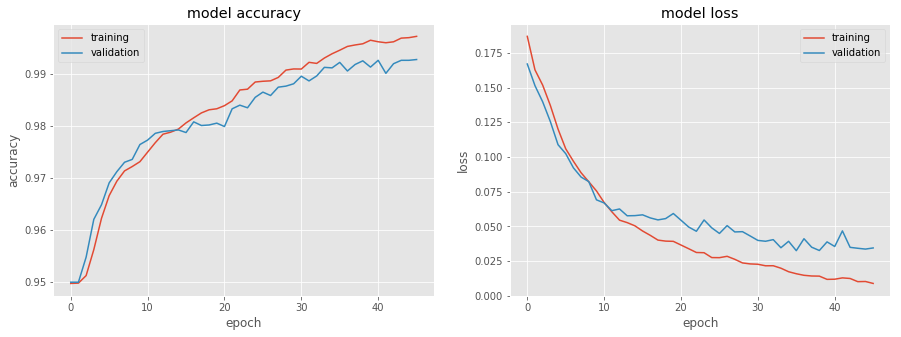

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [11]:
loss, accuracy = model.evaluate(x_valid, y_valid)
print("Validation loss :: {}".format(loss))
print("Validation acc  :: {}".format(accuracy))

1000/1000 [==============================] - 1s 604us/step
Validation loss :: 0.03695817415416241
Validation acc  :: 0.9920499920845032


## Target 2 : Clinical procedures classification
### Read the data and split into 3 datasets
##### 10,000 inpatients records with 15384 clinical binarized descriptors

In [5]:
x2 = pd.read_csv("data/y2/BPPR-pre-trained-2008.txt", sep=",", header=None)
y2 = pd.read_csv("data/y2/labels_Y2-pre-trained-2008.txt", sep=",", header=None)

In [6]:
print("X2 contains {} columns for {} inpatients".format(x2.shape[1], x2.shape[0]))
print("Y2 contains {} categories".format(y2.shape[1]))

X2 contains 15384 columns for 10000 inpatients
Y2 contains 284 categories


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x2.values, y2.values, test_size=0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5)
input_shape = (x_train.shape[1],)
num_classes = y_train.shape[1]

In [8]:
model = create_model(decay_rate=0.4, neurons=input_shape[0])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6153)              94663905  
_________________________________________________________________
dropout_1 (Dropout)          (None, 6153)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2461)              15144994  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2461)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 984)               2422608   
_________________________________________________________________
dropout_3 (Dropout)          (None, 984)               0   

In [9]:
checkpoint = keras.callbacks.ModelCheckpoint('models/basic_classifier_Y2_best_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train, y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[es, checkpoint],
                    validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 1000 samples
Epoch 1/1000
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0176 - accuracy: 0.9965 - val_loss: 0.0150 - val_accuracy: 0.9967
Epoch 2/1000
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0124 - accuracy: 0.9972 - val_loss: 0.0115 - val_accuracy: 0.9975
Epoch 4/1000
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.0106 - val_accuracy: 0.9977
Epoch 5/1000
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.0096 - val_accuracy: 0.9980
Epoch 6/1000
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.0092 - val_accuracy: 0.9980
Epoch 7/1000
8000/8000 [==============================] - 12s 1ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.008

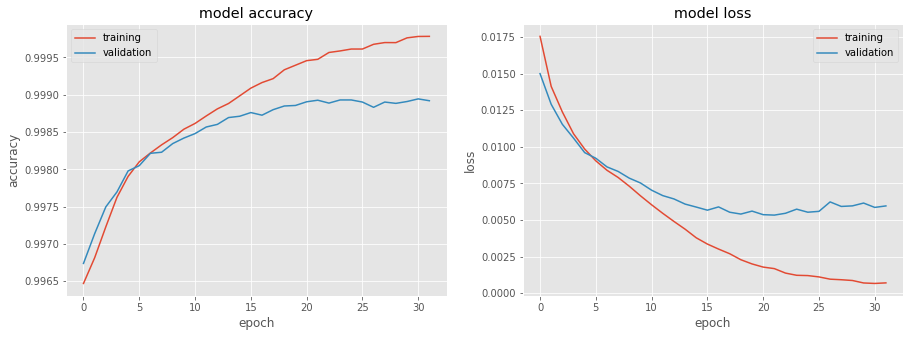

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [11]:
loss, accuracy = model.evaluate(x_valid, y_valid)
print("Validation loss :: {}".format(loss))
print("Validation acc  :: {}".format(accuracy))

1000/1000 [==============================] - 1s 896us/step
Validation loss :: 0.005421545434451673
Validation acc  :: 0.9989683628082275


## Target 3 : Destination classification
### Read the data and split into 3 datasets
##### 10,000 inpatients records with 12285 clinical binarized descriptors

In [2]:
x3 = pd.read_csv("data/y3/BPPR-KMM_x1_x2_x3_x4_x5_x7_x83_x9_x10_Y3-2008.txt", sep=",", header=None)
y3 = pd.read_csv("data/y3/labels_Y3-KMM_x1_x2_x3_x4_x5_x7_x83_x9_x10_Y3-2008.txt", sep=",", header=None)

In [3]:
print("X3 contains {} columns for {} inpatients".format(x3.shape[1], x3.shape[0]))
print("Y3 contains {} categories".format(y3.shape[1]))

X3 contains 12285 columns for 10000 inpatients
Y3 contains 5 categories


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x3.values, y3.values, test_size=0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5)
input_shape = (x_train.shape[1],)
num_classes = y_train.shape[1]

In [8]:
model = create_model(decay_rate=0.4, neurons=input_shape[0])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12285)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4914)              60373404  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4914)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1965)              9657975   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1965)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 786)               1545276   
_________________________________________________________________
dropout_3 (Dropout)          (None, 786)               0   

In [9]:
checkpoint = keras.callbacks.ModelCheckpoint('models/basic_classifier_Y3_best_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train, y_train,  
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[es, checkpoint],
                    validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 1000 samples
Epoch 1/1000
8000/8000 [==============================] - 10s 1ms/step - loss: 0.4980 - accuracy: 0.8000 - val_loss: 0.4920 - val_accuracy: 0.8000
Epoch 2/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.4054 - accuracy: 0.8429 - val_loss: 0.2703 - val_accuracy: 0.9112
Epoch 3/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.2656 - accuracy: 0.9040 - val_loss: 0.1818 - val_accuracy: 0.9332
Epoch 4/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.1828 - accuracy: 0.9355 - val_loss: 0.1680 - val_accuracy: 0.9360
Epoch 5/1000
8000/8000 [==============================] - 8s 1ms/step - loss: 0.1576 - accuracy: 0.9408 - val_loss: 0.1535 - val_accuracy: 0.9420
Epoch 6/1000
8000/8000 [==============================] - 8s 991us/step - loss: 0.1427 - accuracy: 0.9440 - val_loss: 0.1520 -

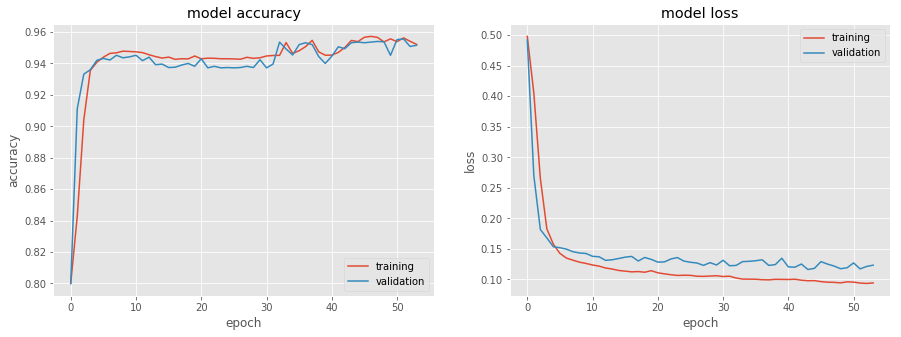

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [11]:
loss, accuracy = model.evaluate(x_valid, y_valid)
print("Validation loss :: {}".format(loss))
print("Validation acc  :: {}".format(accuracy))

1000/1000 [==============================] - 1s 590us/step
Validation loss :: 0.13725999838113784
Validation acc  :: 0.950200080871582


#### Hyperparameters